# LSTM

In [1]:
from abc import ABC, abstractmethod
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union
from IPython.display import HTML, clear_output
np.random.seed(42)

In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./data/arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:128], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

In [3]:
tokens = list(set(''.join(lines)))

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

num_tokens =  136


In [4]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
token_to_id

{'T': 0,
 '2': 1,
 '%': 2,
 'c': 3,
 'x': 4,
 'b': 5,
 ' ': 6,
 'r': 7,
 'ï': 8,
 '=': 9,
 '.': 10,
 'f': 11,
 'u': 12,
 '!': 13,
 '}': 14,
 'N': 15,
 'y': 16,
 'ô': 17,
 'Y': 18,
 'Q': 19,
 'l': 20,
 'á': 21,
 'õ': 22,
 'τ': 23,
 'i': 24,
 ':': 25,
 ';': 26,
 'H': 27,
 'ś': 28,
 'm': 29,
 'I': 30,
 '8': 31,
 '-': 32,
 'A': 33,
 '5': 34,
 'L': 35,
 'v': 36,
 'a': 37,
 '$': 38,
 ')': 39,
 'Ö': 40,
 'K': 41,
 ',': 42,
 'ê': 43,
 'ü': 44,
 'g': 45,
 'o': 46,
 'F': 47,
 '<': 48,
 'S': 49,
 'ã': 50,
 'k': 51,
 'α': 52,
 'W': 53,
 '\x7f': 54,
 '?': 55,
 'í': 56,
 '@': 57,
 'â': 58,
 'γ': 59,
 'e': 60,
 'Z': 61,
 '{': 62,
 '#': 63,
 'Π': 64,
 'd': 65,
 'D': 66,
 'Ω': 67,
 'ρ': 68,
 'z': 69,
 '1': 70,
 'ä': 71,
 '&': 72,
 'P': 73,
 'R': 74,
 '+': 75,
 'χ': 76,
 '"': 77,
 'à': 78,
 '(': 79,
 '|': 80,
 'n': 81,
 '/': 82,
 '3': 83,
 'h': 84,
 '7': 85,
 "'": 86,
 'ö': 87,
 'O': 88,
 'ν': 89,
 'ó': 90,
 'ω': 91,
 'V': 92,
 '4': 93,
 '*': 94,
 'q': 95,
 'j': 96,
 '\n': 97,
 'J': 98,
 'λ': 99,
 'æ': 

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000], token_to_id))

 Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layer

 Exploring Deep and Recurrent Architectures for Optimal Control ; Sophisticated multilayer neural networks have achieved state of

 Space and camera path reconstruction for omni-directional vision ; In this paper, we address the inverse problem of reconstructi

 Provable Algorithms for Inference in Topic Models ; Recently, there has been considerable progress on designing algorithms with 

 Fixing Weight Decay Regularization in Adam ; L$_2$ regularization and weight decay regularization are equivalent for standard st

 Query-Efficient Imitation Learning for End-to-End Autonomous Driving ; One way to approach end-to-end autonomous driving is to l

 Multiple Kernel Learning and Automatic Subspace Relevance Determination   for High-dimensional Neuroimaging Data ; Alzheimer's d

 A Search for Improved Performance in Regular Expressions ; The primary aim of auto

In [8]:
MAX_LENGTH = max(map(len, lines))
sample = to_matrix(np.random.choice(lines, size=5), token_to_id, max_len=MAX_LENGTH)

In [9]:
MAX_LENGTH

130

In [10]:
# dummy
encoded_data = np.zeros(shape=(5, MAX_LENGTH, len(token_to_id)))

for text_i, text in enumerate(encoded_data):
    for letter_i, letter in enumerate(text):
        encoded_data[text_i, letter_i, sample[text_i, letter_i]] = 1

encoded_data.shape

(5, 130, 136)

In [14]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class LinearLSTM(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return x.dot(self.w) + self.b

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)

        return w_grad, b_grad, input_error

    def step(self, w_grad, b_grad):
        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)

class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass

class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

class Embedding(BaseLayer):
    def __init__(self, n_input, emb_dim, pad_idx=None):
        self.n_input = n_input
        self.emb_dim = emb_dim
        self.pad_idx = pad_idx
        
        self.weights = np.random.normal(scale=np.sqrt(2/(n_input+emb_dim)), size=(n_input, emb_dim))

    def set_optimizer(self, optimizer):
        self.weights_optimizer = copy.copy(optimizer)

        self.weights_optimizer.set_weight(self.weights)

    def forward(self, x, grad=True):
        self.input = x
        return self.weights[x]

    def backward(self, output_error):
        weights_grad = np.zeros_like(self.weights)
        input_shape_len = len(self.input.shape)

        if input_shape_len == 2:
            for batch_n, s in enumerate(self.input):
                for i, emb_i in enumerate(s):
                    weights_grad[emb_i] += output_error[batch_n][i]

        elif input_shape_len == 1:
            for i, emb_i in enumerate(self.input):
                weights_grad[emb_i] += output_error[i]

        if self.pad_idx is not None:
            weights_grad[self.pad_idx] = 0

        self.weights = self.weights_optimizer.step(weights_grad)

In [15]:
def tanh(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function
    """
    return np.tanh(z)

def tanh_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function derivative
    """
    return 1 - np.tanh(z) ** 2

def sigmoid(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function
    """
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function derivative
    """
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def softmax(z: np.array) -> np.array:
    """
    Softmax function
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)

def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)

![](./images/lstm.png)
![](./images/graph_meanings.png)

In [16]:
class LSTM:
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        bptt_trunc=4
    ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.bptt_trunc = bptt_trunc
        
        self.forget_gate = LinearLSTM(n_input + n_hidden, n_hidden)
        self.forget_gate_activation = Activation(sigmoid, sigmoid_derivative)
        
        self.input_layer_gate = LinearLSTM(n_input + n_hidden, n_hidden)
        self.input_layer_gate_activation = Activation(sigmoid, sigmoid_derivative)
        
        self.candidate_gate = LinearLSTM(n_input + n_hidden, n_hidden)
        self.candidate_gate_activation = Activation(tanh, tanh_derivative)
        
        self.output_gate = LinearLSTM(n_input + n_hidden, n_hidden)
        self.output_gate_activation = Activation(sigmoid, sigmoid_derivative)
        
        self.output_to_logits = LinearLSTM(n_hidden, n_output)
        
        self.x_and_h = None
        self.hidden_states = None
        self.cell_states = None
        
        self.forget_inputs = None
        self.forget_states = None
        
        self.input_inputs = None
        self.input_states = None
        
        self.candidate_inputs = None
        self.candidate_states = None
        
        self.output_input = None
        self.output_states = None
        
        self.outputs = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def set_optimizer(self, optimizer) -> None:
        self.forget_gate.set_optimizer(optimizer)
        self.input_layer_gate.set_optimizer(optimizer)
        self.candidate_gate.set_optimizer(optimizer)
        self.output_gate.set_optimizer(optimizer)
        self.output_to_logits.set_optimizer(optimizer)
        
    def forward(self, x):
        self.input = x
        batch_size, timesteps, input_dim = x.shape
        
        self.x_and_h = np.zeros((batch_size, timesteps, self.n_input+self.n_hidden))
        self.hidden_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        self.cell_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        
        self.forget_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.forget_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.input_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.input_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.candidate_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.candidate_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.output_input = np.zeros((batch_size, timesteps, self.n_hidden))
        self.output_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.outputs = np.zeros((batch_size, timesteps, self.n_output))

        self.hidden_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        self.cell_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        for t in range(timesteps):
            # соединяем вход и прошлый h
            self.x_and_h[:, t] = np.concatenate((x[:, t], self.hidden_states[:, t-1]), axis=1)
            
            # forget gate проход
            self.forget_inputs[:, t] = self.forget_gate(self.x_and_h[:, t])
            self.forget_states[:, t] = self.forget_gate_activation(self.forget_inputs[:, t])
            
            # выбор кандидатов для C
            self.input_inputs[:, t] = self.input_layer_gate(self.x_and_h[:, t])
            self.input_states[:, t] = self.input_layer_gate_activation(self.input_inputs[:, t])
            
            self.candidate_inputs[:, t] = self.candidate_gate(self.x_and_h[:, t])
            self.candidate_states[:, t] = self.candidate_gate_activation(self.candidate_inputs[:, t])
            
            self.cell_states[:, t] = self.forget_states[:, t] * self.cell_states[:, t-1]\
            + self.input_states[:, t] * self.candidate_states[:, t]
            
            self.output_input[:, t] = self.output_gate(self.x_and_h[:, t])
            self.output_states[:, t] = self.output_gate_activation(self.output_input[:, t])
            
            self.hidden_states[:, t] = self.output_states[:, t] * tanh(self.cell_states[:, t])
            
            # дополнительный слой, не указан на рисунке, для перевода состояния в логиты выхода
            self.outputs[:, t] = self.output_to_logits(self.hidden_states[:, t])

        return self.outputs
    
    def backward(self, output_error):        
        _, timesteps, _ = output_error.shape

        forgate_gate_w_grad = np.zeros_like(self.forget_gate.w)
        forgate_gate_b_grad = np.zeros_like(self.forget_gate.b)

        input_layer_gate_w_grad = np.zeros_like(self.input_layer_gate.w)
        input_layer_gate_b_grad = np.zeros_like(self.input_layer_gate.b)

        candidate_gate_w_grad = np.zeros_like(self.candidate_gate.w)
        candidate_gate_b_grad = np.zeros_like(self.candidate_gate.b)

        output_gate_w_grad = np.zeros_like(self.output_gate.w)
        output_gate_b_grad = np.zeros_like(self.output_gate.b)

        output_to_logits_w_grad = np.zeros_like(self.output_to_logits.w)
        output_to_logits_b_grad = np.zeros_like(self.output_to_logits.b)
        
        input_error = np.zeros_like(self.input)
        
        for t in np.arange(timesteps)[::-1]:
            # в разные моменты времени у слоев был разный вход, необходимо искусственно его поменять
            self.forget_gate.input = self.x_and_h[:, t]
            self.forget_gate_activation.input = self.forget_inputs[:, t]
            self.input_layer_gate.input = self.x_and_h[:, t]
            self.input_layer_gate_activation.input = self.input_inputs[:, t]
            self.candidate_gate.input = self.x_and_h[:, t]
            self.candidate_gate_activation.input = self.candidate_inputs[:, t]
            self.output_gate.input = self.x_and_h[:, t]
            self.output_gate_activation.input = self.output_input[:, t]
            self.output_to_logits.input = self.hidden_states[:, t]
            
            # проход по нижнему уровню
            w_grad, b_grad, hidden_error = self.output_to_logits.backward(output_error[:, t])
            output_to_logits_w_grad += w_grad
            output_to_logits_b_grad += b_grad
            
            # та, что идет вверх
            cell_error = tanh_derivative(self.cell_states[:, t]) * self.output_states[:, t] * hidden_error
            
            # ошибка идет и вниз и вверх
            hidden_error = self.output_gate_activation.backward(hidden_error) * tanh(self.cell_states[:, t])
            
            # та, что идет вниз
            w_grad, b_grad, hidden_error = self.output_gate.backward(hidden_error)
            output_gate_w_grad += w_grad
            output_gate_b_grad += b_grad
            
            # идем по верху
            hidden_candidate_error = self.candidate_gate_activation.backward(cell_error) * self.input_states[:, t]
            w_grad, b_grad, hidden_candidate_error = self.candidate_gate.backward(hidden_candidate_error)
            candidate_gate_w_grad += w_grad
            candidate_gate_b_grad += b_grad
            
            hidden_inputs_error = self.input_layer_gate_activation.backward(cell_error) * self.candidate_states[:, t]
            w_grad, b_grad, hidden_inputs_error = self.input_layer_gate.backward(hidden_inputs_error)
            input_layer_gate_w_grad += w_grad
            input_layer_gate_b_grad += b_grad
            
            hidden_forget_error = self.forget_gate_activation.backward(cell_error) * self.cell_states[:, t-1]
            w_grad, b_grad, hidden_forget_error = self.forget_gate.backward(hidden_forget_error)
            forgate_gate_w_grad += w_grad
            forgate_gate_b_grad += b_grad
            
            # добавляются ошибки с мест копии
            hidden_error += hidden_candidate_error
            hidden_error += hidden_inputs_error
            hidden_error += hidden_forget_error

            # ошибка входа
            input_error[:, t] = hidden_error[:, :self.n_input]
            # ошибка, которая по времени уходит по низу назад
            hidden_error = hidden_error[:, self.n_input:]
            # ошибка, которая по времени уходит по верху назад
            cell_error = cell_error * self.forget_states[:, t]
            
            for t_ in np.arange(max(0, t - self.bptt_trunc), t)[::-1]:
                # проход по времени
                self.forget_gate.input = self.x_and_h[:, t_]
                self.forget_gate_activation.input = self.forget_inputs[:, t_]
                self.input_layer_gate.input = self.x_and_h[:, t_]
                self.input_layer_gate_activation.input = self.input_inputs[:, t_]
                self.candidate_gate.input = self.x_and_h[:, t_]
                self.candidate_gate_activation.input = self.candidate_inputs[:, t_]
                self.output_gate.input = self.x_and_h[:, t_]
                self.output_gate_activation.input = self.output_input[:, t_]
                
                # та, что идет по верху
                cell_error += tanh_derivative(self.cell_states[:, t_]) * self.output_states[:, t_]\
                * hidden_error
                
                hidden_error = self.output_gate_activation.backward(hidden_error) * tanh(self.cell_states[:, t_])
                # та, что идет вниз
                w_grad, b_grad, hidden_error = self.output_gate.backward(hidden_error)
                output_gate_w_grad += w_grad
                output_gate_b_grad += b_grad
                
                hidden_candidate_error = self.candidate_gate_activation.backward(cell_error) * self.input_states[:, t_]
                w_grad, b_grad, hidden_candidate_error = self.candidate_gate.backward(hidden_candidate_error)
                candidate_gate_w_grad += w_grad
                candidate_gate_b_grad += b_grad

                hidden_inputs_error = self.input_layer_gate_activation.backward(cell_error) * self.candidate_states[:, t_]
                w_grad, b_grad, hidden_inputs_error = self.input_layer_gate.backward(hidden_inputs_error)
                input_layer_gate_w_grad += w_grad
                input_layer_gate_b_grad += b_grad

                hidden_forget_error = self.forget_gate_activation.backward(cell_error) * self.cell_states[:, t_-1]
                w_grad, b_grad, hidden_forget_error = self.forget_gate.backward(hidden_forget_error)
                forgate_gate_w_grad += w_grad
                forgate_gate_b_grad += b_grad
                
                # добавляются ошибки с мест копии
                hidden_error += hidden_candidate_error
                hidden_error += hidden_inputs_error
                hidden_error += hidden_forget_error

                # ошибка входа
                input_error[:, t_] += hidden_error[:, :self.n_input]
                # ошибка которая по времени уходит по низу назад
                hidden_error = hidden_error[:, self.n_input:]
                cell_error = cell_error * self.forget_states[:, t_]

        self.forget_gate.step(forgate_gate_w_grad, forgate_gate_b_grad)
        self.input_layer_gate.step(input_layer_gate_w_grad, input_layer_gate_b_grad)
        self.candidate_gate.step(candidate_gate_w_grad, candidate_gate_b_grad)
        self.output_gate.step(output_gate_w_grad, output_gate_b_grad)
        self.output_to_logits.step(output_to_logits_w_grad, output_to_logits_b_grad)

        return input_error

![](./images/lstm_output.png)

In [17]:
emb_size = 16
emb = Embedding(len(token_to_id), emb_size)

encoded_data = emb(sample)
print(encoded_data.shape)

lstm_unit = LSTM(n_input=emb_size,
                 n_hidden=64,
                 n_output=len(token_to_id),
                 bptt_trunc=15)

lstm_unit.set_optimizer(ADAM())

(5, 130, 16)


In [18]:
lstm_unit.forward(encoded_data).shape

(5, 130, 136)

In [19]:
pred = lstm_unit(encoded_data)

loss = 0
for t in range(sample.shape[1]-1):
    loss += cross_entropy_loss(sample[:, t+1].reshape(-1, 1), pred[:, t, :])

errors = np.zeros(shape=(5, MAX_LENGTH-1, len(token_to_id)))
for t in range(errors.shape[1]-1):
    errors[:, t, :] = cross_entropy_loss_derivative(sample[:, t+1].reshape(-1, 1), pred[:, t, :])

err = lstm_unit.backward(errors)

In [21]:
lines

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layer\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial \n',
 ' Multiresolution Recurrent Neural Networks: An Application to Dialogue   Response Generation ; We introduce the multiresolution r\n',
 ' Learning what to share between loosely related tasks ; Multi-task learning is motivated by the observation that humans bring to \n',
 ' A Deep Reinforcement Learning Chatbot ; We present MILABOT: a deep reinforcement learning chatbot developed by the Montreal Inst\n',
 ' Generating Sentences by Editing Prototypes ; We propose a new generative model of sentences that first samples a prototype sente\n',
 ' A Deep Reinforcement Learning Chatbot (Short Version) ; We present MILABOT: a deep reinforcement learning chatbot developed by t\n',
 ' Document Image Coding and Clustering for Scri

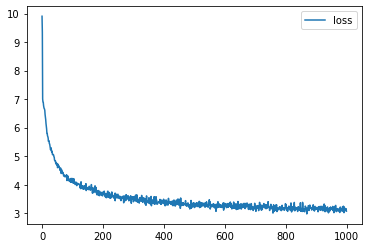

In [25]:
emb_size = 16
emb = Embedding(len(token_to_id), emb_size)
emb.set_optimizer(ADAM(learning_rate=0.01))

lstm_unit = LSTM(
    n_input=emb_size,
    n_hidden=64,
    n_output=len(token_to_id),
    bptt_trunc=MAX_LENGTH
)
lstm_unit.set_optimizer(ADAM(learning_rate=0.01))

batch_size = 64
history = []
for i in range(1000):
    batch_ix = to_matrix(np.random.choice(lines, size=batch_size, replace=False), token_to_id, max_len=MAX_LENGTH)
    
    encoded_data = emb(batch_ix)
    
    pred = lstm_unit(encoded_data)

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    err = lstm_unit.backward(errors)
    emb.backward(err)
    
    # visualizing training process
    history.append(loss / batch_size)
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [26]:
history[-1]

3.0727101786846394

In [27]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    phrase = copy.copy(seed_phrase)
    
    for t in range(len(seed_phrase)-1, max_length-len(seed_phrase)):
        x_sequence = to_matrix([phrase], token_to_id, max_len=max_length)
        encoded_data = emb(x_sequence)

        pred = char_rnn(encoded_data)
        probs = softmax(pred[:, t] / temperature).ravel()
        next_ix = np.random.choice(len(tokens), p=probs)
        phrase += tokens[next_ix]
    return phrase

In [28]:
for _ in range(10):
    print(generate_sample(lstm_unit, seed_phrase=' ', temperature=0.5))

 Learning for Deep many with a searning the word to deep recognition for and scale the-an article in the an action and Sensitive C
 On for Semantic   Representation ; 3D networks and intructation of a parameter Operal Sparial the application ; This paper are fo
 Images ; We propose a novel optimal Semantic Transoge statistical Markong Deep Learning ; We conversion and Processes ; The lavel
 The an and Exploration ; A Unle a consimel sementation ; In this paper many Converming the interves for a new in models ; In this
 A Colling Detection ; This paper is the problem ; We present ; The an and the proposed Systems ; We present Fultionaly and Time a
 Learning to deep sequention for Analysation ; This paper is the a new an architecture problem of Time Diption and an action with 
 System ; The discrition of the information ; A class is a paper model in the and Blation ; The present Transed classification ; W
 Recognition ; In conscoge and Recognition ; The computer search ; We propose a spa

In [29]:
lstm_unit(encoded_data)[1].argmax(axis=1)

array([ 33,  81, 101,  60,   7,  37,  24,  37,   7,   3,   6,  81,  45,
         6,  26,  84,  60,   6,  37,   7,  46,  65,  24,   3, 117,  24,
        46,  60,   6,  37,   7,  20,  60,   7,   6,  37,  11,   6, 117,
        46,  81, 119,  20, 117,  37, 117,  24,  46,  81,   6,  20,   6,
        15,  37, 117,  84,  46,  81,  24,  69,   6,   6,  37,  81,  65,
         6,  37,  81,  46,  60,  29, 117,   6,  33,  60,  37, 117,  24,
         6,  46,  60, 117, 113,  46,   7,  51, 101,   6,  26,  81,   6,
       117,  60,   3,  24,  37,  20,   6,  37,  37, 117,  24,   3,  81,
        26,   6,  53,  84,  60,   6,  60,   6,  37,  81,   6,  37,   6,
        81,  60,  81,  45,  60,   6,  37,  81,  37,  12, 101, 117,   6],
      dtype=int64)

In [30]:
batch_ix[1, 1:]

array([122,  81,  65,  60,   7, 101, 117,  37,  81,  65,  24,  81,  45,
         6, 117,  84,  60,   6,  73,   7,  60,  65,  24,   3, 117,  24,
        36,  60,   6,  73,  46, 113,  60,   7,   6,  46,  11,   6, 128,
        46,  29, 119,  12, 117,  37, 117,  24,  46,  81,  37,  20,   6,
       124,  60,   3,  84,  37,  81,  24,   3, 101,   6,  37,  81,  65,
         6, 127,   3,  84,  46,   6,   6,   6,  49, 117,  37, 117,  60,
         6,  15,  60, 117, 113,  46,   7,  51, 101,   6,  24,  81,   6,
        49,  46,   3,  24,  37,  20,   6, 124,  60,  65,  24,  37,   6,
        26,   6,   0,  84,  60,   7,  60,   6,  24, 101,   6,  37,   6,
        20,  37,   7,  45,  60,   6,  37,  29,  46,  12,  81,  97])

In [24]:
with open('./style.css') as f:
    style = f.read()
HTML(style)